# Automatic Flutter Generation using Sketch UI Mockups


#### Prince Hodonou | Aakash Madabhushi

Mount Google Drive:


In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing all packages here:

In [ ]:
import os
import glob
import csv
import pandas as pd
import numpy as np
import mimetypes
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input
import pickle
from PIL.ImageDraw import Draw
import imutils
from xml.etree.ElementTree import ElementTree
import cv2 as cv
from os import listdir
from matplotlib import image
# import tensorflow_addons as tfa
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization
from numpy import expand_dims
from PIL import Image
from google.colab.patches import cv2_imshow
import xml.etree.ElementTree as ET
import tensorflow as tf
from keras.models import load_model, Model
from keras.layers.merge import add, concatenate
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras import layers,losses,optimizers
from keras.layers import Dense
from keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras.models import load_model
from keras.utils import to_categorical
from keras.applications import VGG16
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

## Prepare Image

In [ ]:
train_images_link = '/content/drive/Shareddrives/CS 577 - Project (Sketch2Code)/dataset/train/images'
train_annotation_link = '/content/drive/Shareddrives/CS 577 - Project (Sketch2Code)/dataset/train/annots'

# val_images_link = '/content/drive/MyDrive/CS 577 - Deep Learning/Project/Datasets/dataset/train2/images/'
# val_annotation_link = '/content/drive/MyDrive/CS 577 - Deep Learning/Project/Datasets/dataset/train2/images/'

# test_images_link = '/content/drive/MyDrive/CS 577 - Deep Learning/Project/Datasets/dataset/train2/images/'
# test_annotation_link = '/content/drive/MyDrive/CS 577 - Deep Learning/Project/Datasets/dataset/train2/images/'

def img_slide_window(img,step,win_size):
    for i in range(0,img.shape[0] - win_size[1],step):
        for j in range(0,img.shape[0] - win_size[0],step):
            yield(j,i,img[i:i + win_size[1], j:j + win_size[0]])

def extract_boxes(filename):
  tree =ET.parse(filename)
  root = tree.getroot()
  boxes = []
  names = []
  for box in root.findall('.//bndbox'):
    xmin = int(box.find('xmin').text)
    ymin = int(box.find('ymin').text)
    xmax = int(box.find('xmax').text)
    ymax = int(box.find('ymax').text)
    coors = [xmin, ymin, xmax, ymax]
    boxes.append(coors)
  
  for box in root.findall('.//object'):
    name = box.find('name').text
    names.append(name)
  
  width = int(root.find('.//size/width').text)
  height = int(root.find('.//size/height').text)
  return boxes, names, width, height

def draw_bounding_box(dimensions, name, img):
  x1 = dimensions[0]
  y1 = dimensions[1]
  x2 = dimensions[2]
  y2 = dimensions[3]
  cv.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
  cv.putText(img, name , (x1, y1), cv.FONT_HERSHEY_SIMPLEX,1,(255,0,0), 2)

def display_image(image_name):
  img = cv.imread(train_images_link + "/" + image_name + ".png")
  boxes, names, w, h = extract_boxes(train_annotation_link + "/" + image_name + ".xml")
  for i, box in enumerate(boxes):
    draw_bounding_box(box, names[i], img)
  cv2_imshow(img)

def dataset_to_csv():
  with open('train.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image', 'label', 'x1', 'y1', 'x2', 'y2', 'w', 'h'])
    for image_name in listdir(train_annotation_link):
      link = train_annotation_link + "/" + image_name
      if image_name != '~$00011.xml':
        boxes, names, w, h = extract_boxes(link)
        for i, box in enumerate(boxes):
          writer.writerow([image_name, names[i], box[0], box[1], box[2], box[3], w, h])
  

In [ ]:
dataset_to_csv()

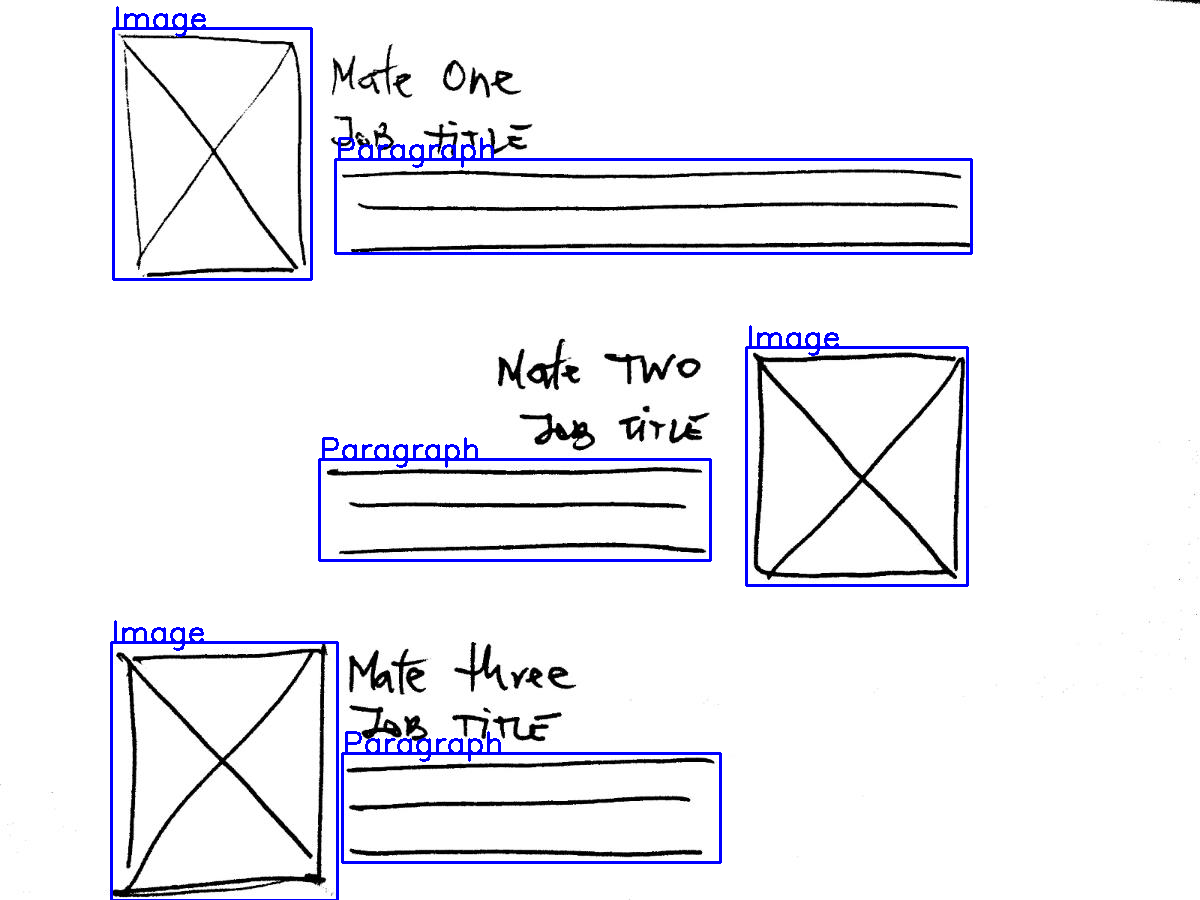

14
['Image' 'Paragraph' 'Heading' 'Textbox' 'Button' 'Check Box'
 'Radio Button' 'Select' 'Carousel' 'Label' 'Table' 'Link' 'Textarea'
 'Pagination']


,image,label,x1,y1,x2,y2,w,h
0,00034.xml,Image,744,353,974,597,1200,900
1,00034.xml,Image,91,626,316,870,1200,900
2,00034.xml,Image,138,6,324,260,1200,900
3,00034.xml,Paragraph,351,153,985,275,1200,900
4,00034.xml,Paragraph,320,448,710,566,1200,900


In [ ]:
display_image('00015')
train = pd.read_csv('train.csv')
classes_num = len(train['label'].unique())
print(classes_num)
print(train['label'].unique())
train.head()

## Pre-processing


In [ ]:
binarizer = LabelBinarizer()
def preprocess():
  image_data = []
  labels = []
  boxes = []
  image_paths = []
  #PREPROCESSING
  rows = open('./train.csv').read().strip().split("\n")
  print('----PREPROCESSING DATASET----')
  for i, row in enumerate(rows):
    if i!=0:
      row = row.split(",")
      (image_name, label, x1, y1, x2, y2, w, h) = row
      image_path = train_images_link + "/" + image_name.split('.')[0] + ".png"
      w, h = float(w), float(h)
      x1 = float(x1) / w
      y1 = float(y1) / h
      x2 = float(x2) / w
      y2 = float(y2) / h
      image = load_img(image_path, target_size=(224, 224))
      image = img_to_array(image)
      image_data.append(image)
      labels.append(label)
      boxes.append([x1, y1, x2, y2])
      image_paths.append(image_path)
  image_data = np.array(image_data, dtype="float32")
  image_data = preprocess_input(image_data) 
  labels = binarizer.fit_transform(np.array(labels))
  boxes = np.array(boxes, dtype="float32")
  image_paths = np.array(image_paths)
  return image_data, labels, boxes, image_paths

In [ ]:
#Loss functions (Regression)

mse = losses.mean_squared_error
mae = losses.mean_absolute_error
huber = losses.huber
log_cosh = losses.logcosh

In [ ]:
dict_param = dict(loss=[mse,mae,huber,log_cosh])
l_loss = ['mse','mae','huber','log_cosh']

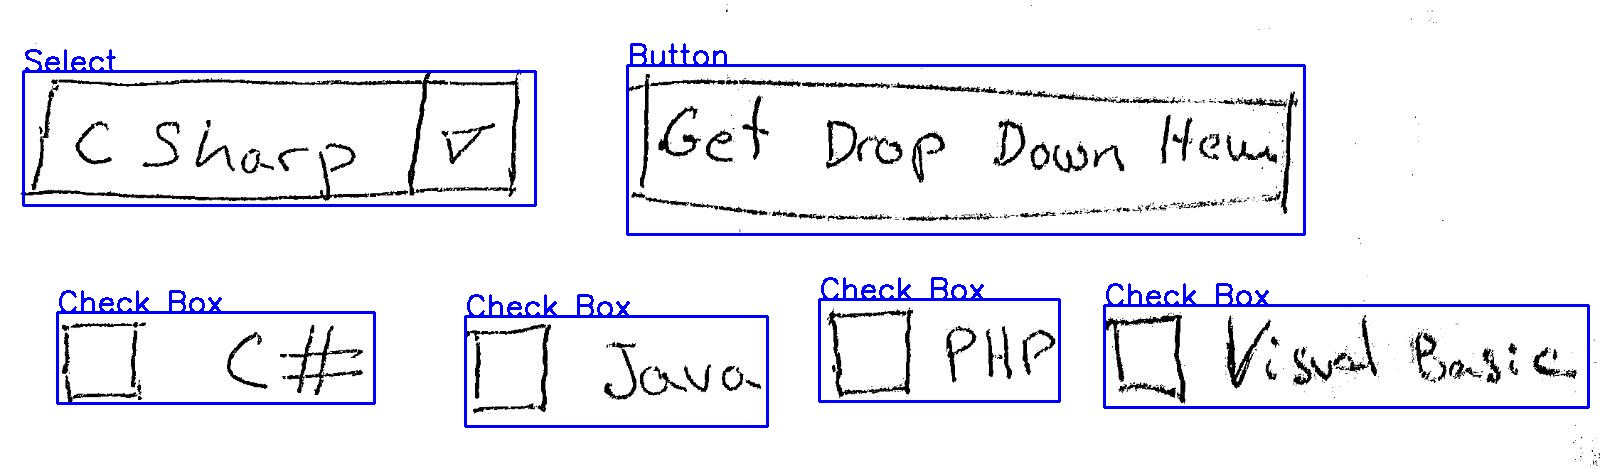

In [ ]:
display_image('00014')

## Neural Network

In [ ]:
def train(training, learning_rate = 1e-4, epochs = 90, batch_size=45):
  image_data = training['image_data']
  labels = training['labels']
  boxes = training['boxes']
  image_paths = training['image_paths']
  split_data = train_test_split(image_data, labels, boxes, image_paths, 
                                test_size=0.20, random_state = 42)
  (train_images, test_images) = split_data[:2]
  (train_labels, test_labels) = split_data[2:4]
  (train_boxes, test_boxes) = split_data[4:6]
  (train_image_paths, test_image_paths) = split_data[6:]

  #MODEL
  vgg = VGG16(weights="imagenet", include_top=False, 
              input_tensor = Input(shape=(224, 224, 3)))
  vgg.trainable = False
  flatten = Flatten()(vgg.output)
  #layers for the bounding boxes
  bounding_box_layer = Dense(128, activation="relu")(flatten)
  bounding_box_layer = Dense(64, activation="relu")(bounding_box_layer)
  bounding_box_layer = Dense(32, activation="relu")(bounding_box_layer)
  bounding_box_layer = Dense(16, activation="relu")(bounding_box_layer)
  bounding_box_layer = Dense(8, activation="relu")(bounding_box_layer)
  bounding_box_layer = Dense(4, activation="sigmoid", name="bounding_box")(bounding_box_layer)
  #layers for labels
  classification_layer = Dense(256, activation="relu")(flatten)
  classification_layer = Dropout(0.5)(classification_layer)
  classification_layer = Dense(128, activation="relu")(classification_layer)
  classification_layer = Dropout(0.5)(classification_layer)
  classification_layer = Dense(classes_num, activation="softmax", name="widget_label")(classification_layer)
  model = Model(inputs = vgg.input, outputs=(bounding_box_layer, classification_layer))
  print('----COMPILING MODEL----')
  for i,los in enumerate(dict_param['loss']):

    model.compile(
        loss={"bounding_box": los, "widget_label": 'categorical_crossentropy'},
        optimizer = optimizers.SGD(lr = learning_rate, momentum = 0.9),
        metrics=["accuracy"],
        loss_weights={ "bounding_box": 1.0, "widget_label": 1.0}
    )
    print(model.summary())
    train_targets = {
        "bounding_box": train_boxes,
        "widget_label": train_labels,
    }
    test_targets = {
        "bounding_box": test_boxes,
        "widget_label": test_labels,
    }
    print('----TRAINING MODEL----')
    print("Optimizers: ",l_loss[i])
    result = model.fit(
        train_images, train_targets,
        validation_data=(test_images, test_targets),
        batch_size = batch_size,
        epochs = 20)
    
    print(result.history.keys())
    
    print("Results: ",model.evaluate(test_images,test_targets))
    plt.plot(range(1,len(result.history['val_loss'])+1),result.history['val_loss'],label=l_loss[i]+'-'+'adam')
    model.save('widget_detector', save_format="h5")
    f_binarizer = open('binarizer', 'wb')
    f_binarizer.write(pickle.dumps(binarizer))
    f_binarizer.close()

  plt.xlabel('Epoch')
  plt.ylabel('Val Loss')
  plt.legend(loc='right')
  plt.show()  

  return result, model

In [ ]:
# f_binarizer = open('binarizer', 'wb')
# f_binarizer.write(pickle.dumps(binarizer))
# f_binarizer.close()

In [ ]:
#Preprocess images
with tf.device('/device:GPU:0'):
    image_data, labels, boxes, image_paths = preprocess()

----PREPROCESSING DATASET----


58892288/58889256 [==============================] - 0s 0us/step
----COMPILING MODEL----
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
_____

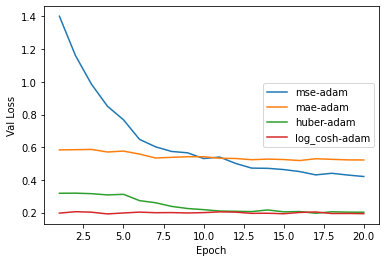

In [ ]:
#Model Training
with tf.device('/device:GPU:0'):
  result,model = train({
      'image_data': image_data,
      'labels': labels,
      'boxes': boxes,
      'image_paths': image_paths,
  })

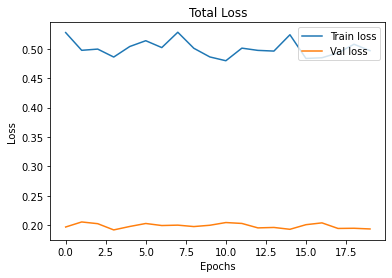

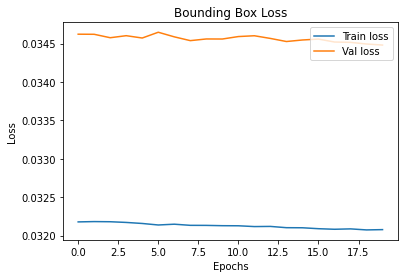

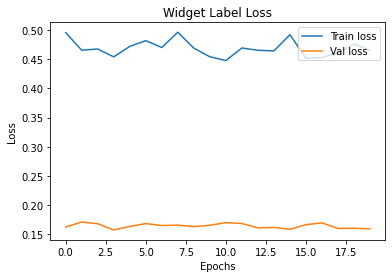

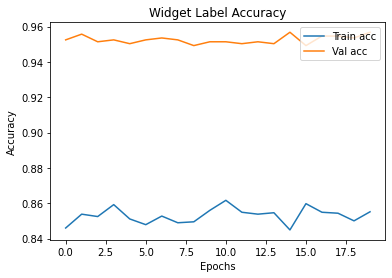

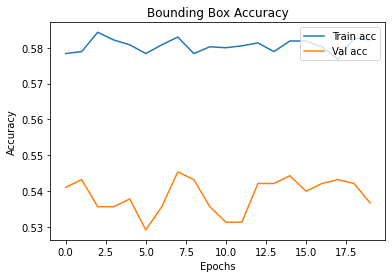

In [ ]:
loss_measured = ["loss", "widget_label_loss", "bounding_box_loss"]
N = np.arange(0, 20)

plt.figure()
plt.plot(N, result.history["loss"],
	label="Train loss")
plt.plot(N, result.history["val_loss"],
	label="Val loss")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig('total_loss')

plt.figure()
plt.plot(N, result.history["bounding_box_loss"],
	label="Train loss")
plt.plot(N, result.history["val_bounding_box_loss"],
	label="Val loss")
plt.title("Bounding Box Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig('bounding_box_loss')

plt.figure()
plt.plot(N, result.history["widget_label_loss"],
	label="Train loss")
plt.plot(N, result.history["val_widget_label_loss"],
	label="Val loss")
plt.title("Widget Label Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig('widget_label_loss')
 
plt.figure()
plt.plot(N, result.history["widget_label_accuracy"],
	label="Train acc")
plt.plot(N, result.history["val_widget_label_accuracy"],
	label="Val acc")
plt.title("Widget Label Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="upper right")
plt.savefig('widget_label_accuracy')

plt.figure()
plt.plot(N, result.history["bounding_box_accuracy"],
	label="Train acc")
plt.plot(N, result.history["val_bounding_box_accuracy"],
	label="Val acc")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="upper right")
plt.savefig('bounding_box_accuracy')

In [ ]:
result.history.keys()

dict_keys(['loss', 'bounding_box_loss', 'widget_label_loss', 'bounding_box_accuracy', 'widget_label_accuracy', 'val_loss', 'val_bounding_box_loss', 'val_widget_label_loss', 'val_bounding_box_accuracy', 'val_widget_label_accuracy'])

In [ ]:
# ['Image' 'Paragraph' 'Heading' 'Textbox' 'Button' 'Check Box'
#  'Radio Button' 'Select' 'Carousel' 'Label' 'Table' 'Link' 'Textarea'
#  'Pagination']

image_widget = """Image(
  image: NetworkImage('https://flutter.github.io/assets-for-api-docs/assets/widgets/owl.jpg'),
)"""
paragraph_widget = """Text(
  'This is a paragraph'
)"""
heading_widget = """Text(
          "Hello World",
          style: Theme.of(context).textTheme.headline6,
)"""
textbox_widget = """TextField(
  decoration: InputDecoration(
    border: OutlineInputBorder(),
    hintText: 'Enter a search term'
  ),
)"""
button_widget = """RaisedButton(
          child: Text("A button"),
          color: Colors.yellow,
          onPressed: () => {},
        )"""
check_box_widget = """Checkbox(
        value: true,
        onChanged: (_) => {},
)"""
radio_button_widget = """Radio<Text>(
        value: Text("Radio 1"),
        groupValue: Text("Radio 1"),
        onChanged: (_) => {},
      )
"""
select_widget = """DropdownButton(
        onChanged: (_) => {},
        items: [
          DropdownMenuItem(
            child: Text('Hello World'),
          ),
        ],
)"""
link_widget = """Text(
        "https://www.google.com/",
        style: TextStyle(
          color: Colors.blue,
          decoration: TextDecoration.underline,
        ),
)"""
textarea_widget = """TextField(
  decoration: InputDecoration(
    border: OutlineInputBorder(),
    hintText: 'Enter a search term'
  ),
)"""
default_widget = """Text(
  'This is a default widget'
)"""

def generate_widget_code(widget):
  if widget == 'Image':
    return image_widget
  elif widget == 'Paragraph':
    return paragraph_widget
  elif widget == 'Heading':
    return heading_widget
  elif widget == 'Textbox':
    return textbox_widget
  elif widget == 'Button':
    return button_widget
  elif widget == 'Check Box':
    return check_box_widget
  elif widget == 'Radio Button':
    return radio_button_widget
  elif widget == 'Select':
    return select_widget
  elif widget == 'Textarea':
    return textarea_widget
  elif widget == 'Link':
    return link_widget
  else:
    return default_widget

## Predicting the image

In [ ]:
import imutils


def predict(image_name):
  w =1200
  h = 900  
  image_path = train_images_link + "/" + image_name + ".png"
  img = cv.imread(image_path)
#   img = imutils.resize(img, width=900)
#   (h, w) = img.shape[:2]
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  model = load_model('/content/widget_detector')
  binarizer = pickle.loads(open('/content/binarizer', "rb").read())
  # train_annotation_link + "/" + image_name + ".xml"
  image = load_img(image_path, target_size=(224, 224))
  image = img_to_array(image)
  image = np.expand_dims(image, axis=0)
#   image = preprocess_input(image) 

  (box_predictions, widget_predictions) = model.predict_generator(image)
  (x1, y1, x2, y2) = box_predictions[0]
  index = np.argmax(widget_predictions, axis=1)
  label = binarizer.classes_[index][0]
  x1 = int(x1*w)
  y1 = int(y1*h)
  x2 = int(x2 * w)
  y2 = int(y2 * h)
  print([x1, y1, x2, y2], label)
  draw_bounding_box([x1, y1, x2, y2], label, img)
  cv2_imshow(img)
  return [x1, y1, x2, y2], label

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[303, 402, 731, 681] Check Box


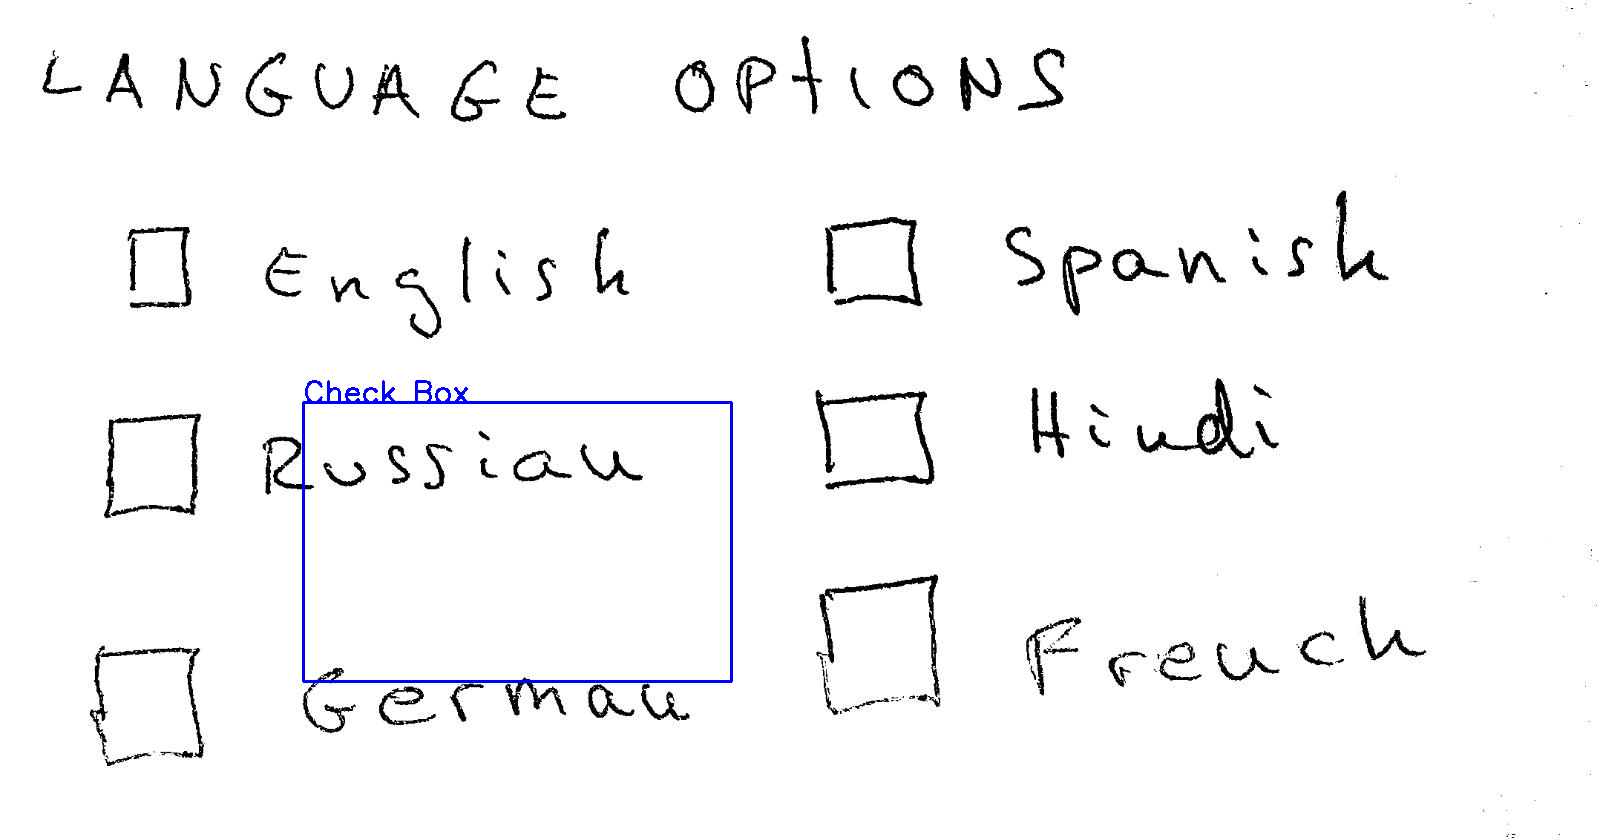

'Checkbox(\n        value: true,\n        onChanged: (_) => {},\n)'

In [ ]:
# image_122
# 00022

boxes, label = predict('image_122')
generate_widget_code(label)